
📊 === Per-Feature Summary ===

                              Real Mean   Synth Mean     Real Std  Synth Std
ABP MAP                       74.157997    83.987000     9.797000      0.032
FiO2 (%)                      44.153999    68.246002    24.075001      0.018
MAP                           72.209999    87.750999    15.544000      0.003
PaO2/FiO2 (Calculated)       200.151993   265.264008    65.189003      0.077
Pulse                        124.199997   154.490997    30.243999      0.047
Resp                          28.318001    41.224998    12.897000      0.011
SpO2                          96.976997   103.449997     6.425000      0.048
Temp                          98.348000   103.337997     4.997000      0.007
ALT (SGPT)                   131.375000   779.908020   648.280029      0.257
ARTERIAL POC PCO2             43.423000    49.506001     6.102000      0.018
ARTERIAL POC PH                7.363000     7.719000     0.357000      0.000
ARTERIAL POC PO2              86.791000   12

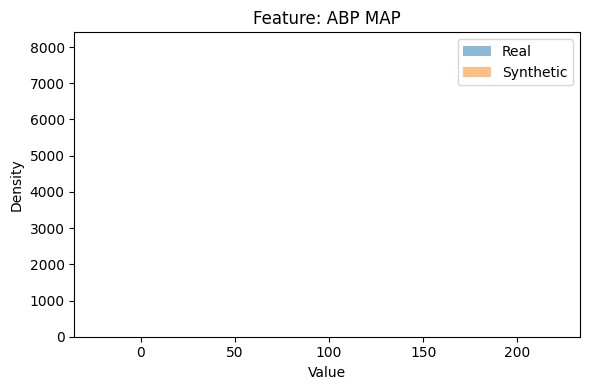

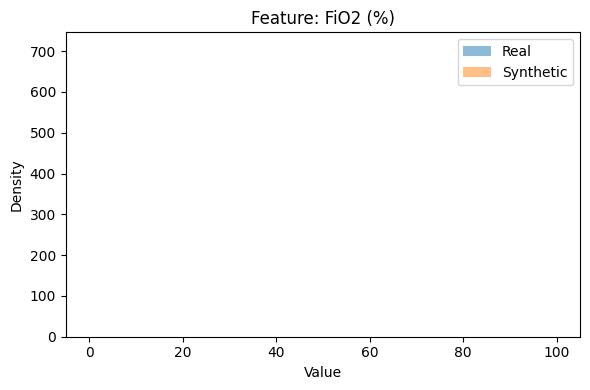

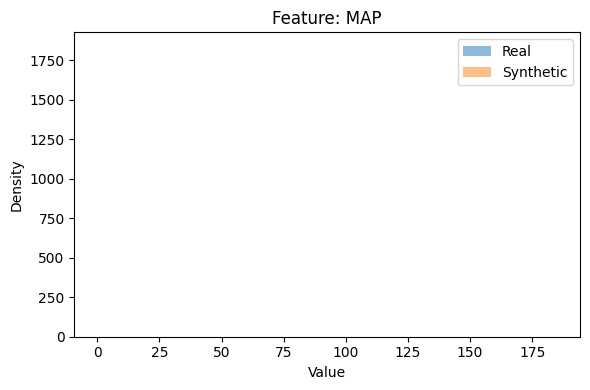

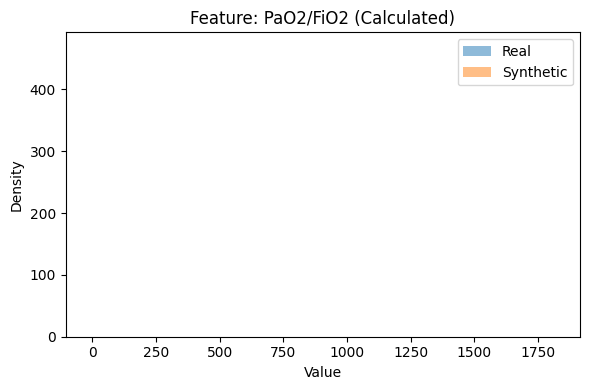

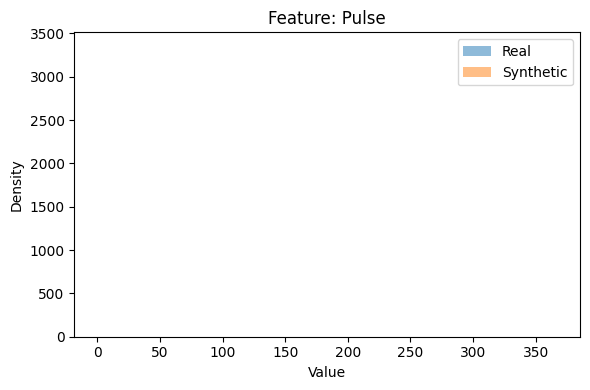


📈 KL (discrete meds): 6.9035894009211844
📈 MMD (continuous vitals): 0.9779973030090332


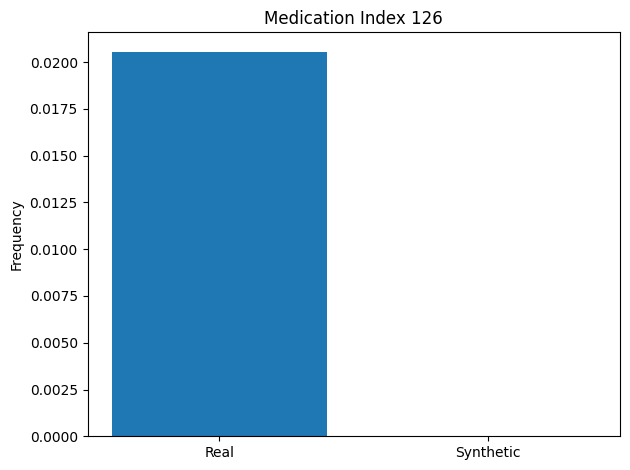

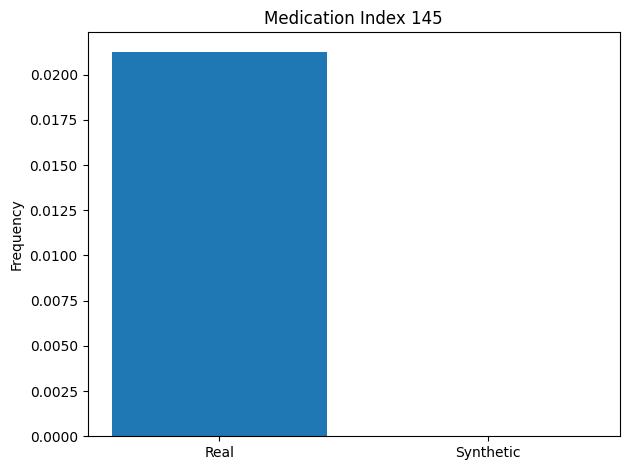

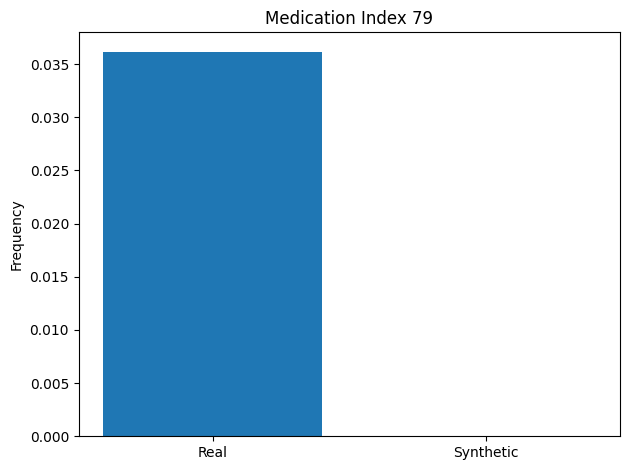

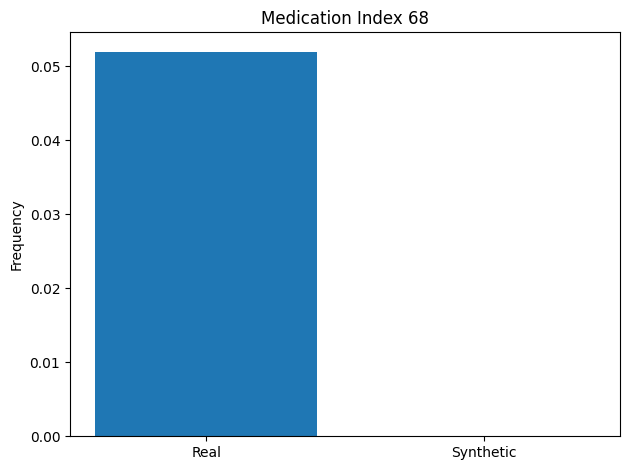

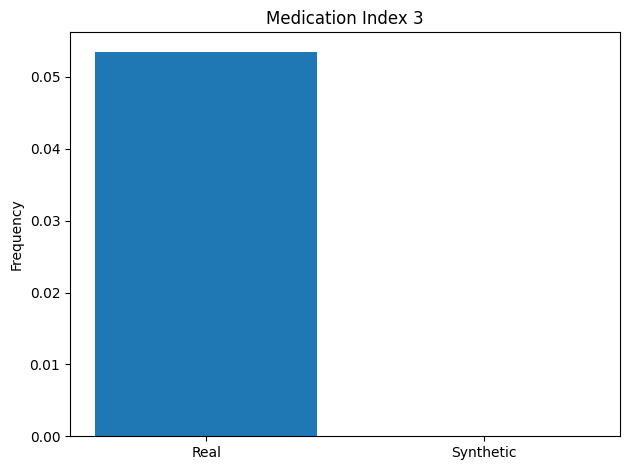


📈 Average KL per medication: 0.0356


In [10]:
import numpy as np
import pandas as pd
import gzip, pickle, os
import matplotlib.pyplot as plt

# === File paths ===
vital_file = r"D:\ehrMGAN\ehrMGANdata\real\mydata\vital_sign_48hrs.pkl"
med_file   = r"D:\ehrMGAN\ehrMGANdata\real\mydata\med_interv_48hrs.pkl"
norm_file  = r"D:\ehrMGAN\ehrMGANdata\real\mydata\norm_stats.npz"

c_gen_path = r"D:\ehrMGAN\data\fake\large_gen_tmp\c_gen_data_mm.npy"
d_gen_path = r"D:\ehrMGAN\data\fake\large_gen_tmp\d_gen_data_mm.npy"

# === Load real data ===
with gzip.open(vital_file, "rb") as f:
    vital_real = pickle.load(f)["data"]  # shape: (N, T, c_dim)
with gzip.open(med_file, "rb") as f:
    med_real = pickle.load(f)["data"]    # shape: (N, T, d_dim)

# === Infer dimensions ===
time_steps = vital_real.shape[1]
c_dim = vital_real.shape[2]
d_dim = med_real.shape[2]
num_gen = 1000000  # total synthetic samples

# === Load synthetic data correctly using np.memmap ===
c_gen = np.memmap(c_gen_path, dtype=np.float32, mode='r', shape=(num_gen, time_steps, c_dim))[:1000]
d_gen = np.memmap(d_gen_path, dtype=np.float32, mode='r', shape=(num_gen, time_steps, d_dim))[:1000]

# === Load normalization stats ===
stats = np.load(norm_file)
mean_c = stats["mean"]
std_c  = stats["std"]
feat_names = stats["feat_names"]

# === Denormalize synthetic continuous data ===
c_gen_denorm = c_gen * std_c + mean_c

# === Flatten time dimension ===
c_gen_flat        = c_gen_denorm.reshape(-1, c_gen_denorm.shape[-1])
vital_real_flat   = vital_real.reshape(-1, vital_real.shape[-1])
med_real_flat     = med_real.reshape(-1, med_real.shape[-1])
d_gen_flat        = d_gen.reshape(-1, d_gen.shape[-1])

# === Compare statistics ===
comparison_df = pd.DataFrame({
    "Real Mean": vital_real_flat.mean(axis=0),
    "Synth Mean": c_gen_flat.mean(axis=0),
    "Real Std": vital_real_flat.std(axis=0),
    "Synth Std": c_gen_flat.std(axis=0)
}, index=feat_names)

print("\n📊 === Per-Feature Summary ===\n")
print(comparison_df.round(3))

# === Inspect first few synthetic samples ===
print("\n📦 First few synthetic samples (t=0):\n")
print(pd.DataFrame(c_gen_denorm[:10, 0, :], columns=feat_names))

# === Plot continuous distributions ===
for i, feat in enumerate(feat_names[:5]):  # modify range to plot more features
    plt.figure(figsize=(6, 4))
    plt.hist(vital_real_flat[:, i], bins=50, alpha=0.5, label="Real", density=True)
    plt.hist(c_gen_flat[:, i], bins=50, alpha=0.5, label="Synthetic", density=True)
    plt.title(f"Feature: {feat}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Distance metrics ===
def kl_divergence(p, q, eps=1e-10):
    p = np.clip(p, eps, 1)
    q = np.clip(q, eps, 1)
    return np.sum(p * np.log(p / q))

def compute_mmd(x, y, gamma=1.0, sample_size=1000000):
    def rbf_kernel(a, b):
        sq_dist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2 * np.dot(a, b.T)
        return np.exp(-gamma * np.maximum(sq_dist, 0))
    n = min(len(x), len(y), sample_size)
    x_sample = x[np.random.choice(len(x), n, replace=False)]
    y_sample = y[np.random.choice(len(y), n, replace=False)]
    return rbf_kernel(x_sample, x_sample).mean() + \
           rbf_kernel(y_sample, y_sample).mean() - \
           2 * rbf_kernel(x_sample, y_sample).mean()

print("\n📈 KL (discrete meds):", kl_divergence(med_real_flat.mean(0), d_gen_flat.mean(0)))
print("📈 MMD (continuous vitals):", compute_mmd(vital_real_flat, c_gen_flat))

# === Plot top 5 most common medications ===
top_meds = np.argsort(med_real_flat.mean(0))[-5:]
for idx in top_meds:
    plt.figure()
    plt.bar(["Real", "Synthetic"], [med_real_flat[:, idx].mean(), d_gen_flat[:, idx].mean()])
    plt.title(f"Medication Index {idx}")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# === KL per med (average) ===
kl_score = kl_divergence(med_real_flat.mean(0), d_gen_flat.mean(0))
kl_score_avg = kl_score / med_real_flat.shape[1]
print(f"\n📈 Average KL per medication: {kl_score_avg:.4f}")


In [11]:
print("Real mean:", med_real_flat[:, 145].mean())
print("Synthetic mean:", d_gen_flat[:, 145].mean())

Real mean: 0.021275654635527247
Synthetic mean: 0.0
